In [1]:
import numpy as np
import cf_xarray
import xarray
from datetime import timedelta
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import zipfile
import os

In [2]:
ds = xarray.open_dataset('https://gcoos5.geos.tamu.edu/thredds/dodsC/ROFS_latest/txla2_his_f_latest_surface.nc')

In [8]:
kml_preamble = '''<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://earth.google.com/kml/2.1">
<Document>
  <name>Time Animation Test</name>
  <open>1</open>
  <description>
    by Rob Hetland
  </description>
  <Folder>
    <name>Frames</name>
'''

kml_frame = '''  <GroundOverlay>
      <TimeSpan>
        <begin>__TIMEBEGIN__</begin>
        <end>__TIMEEND__</end>
      </TimeSpan>
      <color>__COLOR__</color>
      <Icon>
        <href>__FRAME__</href>
      </Icon>
      <LatLonBox>
        <north>__NORTH__</north>
        <south>__SOUTH__</south>
        <east> __EAST__</east>
        <west> __WEST__</west>
      </LatLonBox>
  </GroundOverlay>
'''

kml_legend = '''<ScreenOverlay>
    <name>Legend</name>
    <Icon>
        <href>legend.png</href>
    </Icon>
    <overlayXY x="0" y="0" xunits="fraction" yunits="fraction"/>
    <screenXY x="0.015" y="0.075" xunits="fraction" yunits="fraction"/>
    <rotationXY x="0.5" y="0.5" xunits="fraction" yunits="fraction"/>
    <size x="0" y="0" xunits="pixels" yunits="pixels"/>
</ScreenOverlay>
'''

kml_closing = '''  </Folder>
</Document>
</kml>
'''

name = 'overlay'
color = '9effffff'
visibility = '1'
kmzfile = 'overlay.kmz'
pixels = 300  # pixels of the max. dimension

In [9]:
prop_name = 'salt'
vmin = 25
vmax = 36.5
cmap = cmo.haline
units = 'Salinity [g/kg]'

In [10]:
prop = ds[prop_name].cf.isel(xi_rho=slice(200, None))

# get lat/lon
lon = prop[ds.salt.cf.coordinates['longitude'][0]].values
lat = prop[ds.salt.cf.coordinates['latitude'][0]].values

# get time coordinate boundaries
dt = ds.ocean_time[1] - ds.ocean_time[0]
time_starts = ds.ocean_time.values
time_stops = np.hstack((ds.ocean_time.values[1:], ds.ocean_time[-1].values+dt))

# set aspect ratio for figure, so points are roughly even
geo_aspect = np.cos(lat.mean()*np.pi/180.0)
xsize = lon.ptp()*geo_aspect
ysize = lat.ptp()

aspect = ysize/xsize
if aspect > 1.0:
    figsize = (10.0/aspect, 10.0)
else:
    figsize = (10.0, 10.0*aspect)

Writing frame 0 2021-01-12T01:00:00.000000000, 2021-01-12T02:00:00.000000000


/Users/hetl729/miniconda3/envs/parcels/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  from ipykernel import kernelapp as app


Writing frame 1 2021-01-12T02:00:00.000000000, 2021-01-12T03:00:00.000000000
Writing frame 2 2021-01-12T03:00:00.000000000, 2021-01-12T04:00:00.000000000
Writing frame 3 2021-01-12T04:00:00.000000000, 2021-01-12T05:00:00.000000000
Writing frame 4 2021-01-12T05:00:00.000000000, 2021-01-12T06:00:00.000000000
Writing frame 5 2021-01-12T06:00:00.000000000, 2021-01-12T07:00:00.000000000
Writing frame 6 2021-01-12T07:00:00.000000000, 2021-01-12T08:00:00.000000000
Writing frame 7 2021-01-12T08:00:00.000000000, 2021-01-12T09:00:00.000000000
Writing frame 8 2021-01-12T09:00:00.000000000, 2021-01-12T10:00:00.000000000
Writing frame 9 2021-01-12T10:00:00.000000000, 2021-01-12T11:00:00.000000000
Writing frame 10 2021-01-12T11:00:00.000000000, 2021-01-12T12:00:00.000000000
Writing frame 11 2021-01-12T12:00:00.000000000, 2021-01-12T13:00:00.000000000
Writing frame 12 2021-01-12T13:00:00.000000000, 2021-01-12T14:00:00.000000000
Writing frame 13 2021-01-12T14:00:00.000000000, 2021-01-12T15:00:00.00000

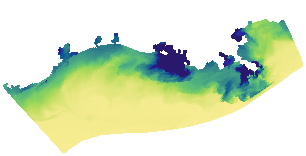

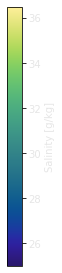

In [11]:
fig = plt.figure(figsize=figsize, dpi=pixels//10, facecolor=None, frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

f = zipfile.ZipFile(kmzfile, 'w', compression=zipfile.ZIP_DEFLATED)

kml_text = kml_preamble

for frame in range(prop.shape[0]):
    tstart =str(time_starts[frame])
    tstop = str(time_stops[frame])
    print(f'Writing frame {frame} {tstart}, {tstop}')
    ax.cla()
    pc = ax.pcolor(lon, lat, prop[frame,0].values, 
                   vmin=vmin, vmax=vmax, cmap=cmap,
                   shading='nearest')
    ax.set_xlim(lon.min(), lon.max())
    ax.set_ylim(lat.min(), lat.max())
    ax.set_axis_off()
    icon = f'overlay_{frame}.png'
    plt.savefig(icon)
    kml_text += kml_frame.replace('__NAME__', name)\
                         .replace('__COLOR__', color)\
                         .replace('__VISIBILITY__', visibility)\
                         .replace('__SOUTH__', str(lat.min()))\
                         .replace('__NORTH__', str(lat.max()))\
                         .replace('__EAST__', str(lon.max()))\
                         .replace('__WEST__', str(lon.min()))\
                         .replace('__FRAME__', icon)\
                         .replace('__TIMEBEGIN__', tstart)\
                         .replace('__TIMEEND__', tstop)

    f.write(icon)
    os.remove(icon)

# legend
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
cax = fig.add_axes([0.0, 0.05, 0.2, 0.90])
cb = plt.colorbar(pc, cax=cax)
cb.set_label(units, color='0.9')
for lab in cb.ax.get_yticklabels():
    plt.setp(lab, 'color', '0.9')

plt.savefig('legend.png')
f.write('legend.png')
os.remove('legend.png')

kml_text += kml_legend

kml_text += kml_closing

f.writestr('overlay.kml', kml_text)

f.close()

/Users/hetl729/miniconda3/envs/parcels/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  This is separate from the ipykernel package so we can avoid doing imports until


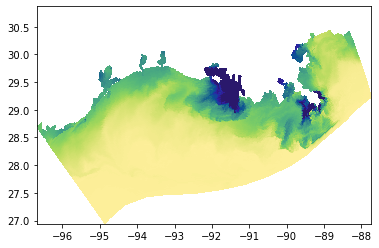

In [12]:
plt.pcolor(lon, lat, prop[frame,0].values, 
                   vmin=20, vmax=36.3, cmap=cmap,
                   shading='nearest')